# py_plda window-based progressive adapt

window안에서 순처적으로 progressive하게 adaptation

In [11]:
%load_ext autoreload
%autoreload 2
%pylab
%matplotlib inline

import os
import sys
import pandas as pd
import pickle
import numpy as np
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
from batch_sv_system import get_embeds, cosine_sim
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_fscore_support

In [3]:
from utils import key2df, df2dict, compute_eer, get_id2idx

embed_dir = "embeddings/voxc2_fbank64_voxc2untied_300f_xvector/"
sv_embeds = np.load(embed_dir + "ln_lda_sv_embeds.npy")
sv_keys = pickle.load(open(embed_dir + "/sv_keys.pkl", "rb"))
sv_id2idx = get_id2idx(sv_keys)

cohort_ids = np.load("trials/dev940_eval311/dev_cohort_ids.npy")
cohort_embeds = get_embeds(cohort_ids, sv_embeds, sv_id2idx, norm=False)

In [4]:
from ioffe_plda.verifier import Verifier
py_plda_model = Verifier()
py_plda_model = Verifier(pickle.load(open("py_plda_model_ln_lda.pkl", "rb")))

In [5]:
def score_trials(enr_embeds, test_embeds, score_method):
        if score_method == "scoreAvg":
            score = py_plda_model.score_avg(enr_embeds, test_embeds).mean(0)
        elif score_method == "vectorAvg":
            score = py_plda_model.vector_avg(enr_embeds, test_embeds).mean(0)
        elif score_method == "multiSessScale":
            score = py_plda_model.multi_sess(enr_embeds, test_embeds, cov_scaling=True).mean(0)
        elif score_method == "multiSessAdapt":
            score = py_plda_model.multi_sess(enr_embeds, test_embeds, cov_adapt=True).mean(0)
        else:
            raise NotImplemtedError
        
        return score

In [6]:
def plot_sorted_scores(scores, labels, sorting=False):
    if sorting:
        sorted_idx = np.flip(np.argsort(scores))
        scores = scores[sorted_idx]
        labels = labels[sorted_idx]
    plt.figure(figsize=[5, 5])
    plt.subplot(2,1,1)
    plt.plot(scores)
    plt.subplot(2,1,2)
    plt.scatter(np.arange(len(labels)), labels)
    plt.show()

In [7]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

def plot_prec_recall(scores, labels, label=None, points=None): 
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})

    prec, recall, ths = precision_recall_curve(labels, scores)
    mAP = average_precision_score(labels, scores)

    plt.figure(figsize=[5,5])
    plt.step(recall, prec, color='b', alpha=1.0, where='post', label=label)
    plt.fill_between(recall, prec, alpha=0.3, color='b', **step_kwargs)
    
    if points:
        for point in points:
            plt.annotate("recall:{:.3f}, prec:{:.3f}".format(point[0], point[1]),
                         xy=point, xycoords='data', xytext=(-90, -50),
                         textcoords='offset points',
                         fontsize=8, arrowprops=dict(arrowstyle="->", color="r"), color="r")

    if label is not None:
        plt.legend()
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title("mAP:{:.3f}".format(mAP))
    plt.show()

## Read Trials 

In [8]:
adapt_trials = pickle.load(open("trials/dev940_eval311/split_trials/adapt_len300_enr3_ptar0.1_cluster_trials.pkl", "rb"))
test_trials = pickle.load(open("trials/dev940_eval311/split_trials/test_random_trials.pkl", "rb"))

adapt_label_list = [tr[-1].label.tolist() for tr in adapt_trials]
adapt_total_labels = np.concatenate(adapt_label_list)
test_label_list = [test_trials[tr[0]['spk']].label.tolist() for tr in adapt_trials]
test_total_labels = np.concatenate(test_label_list)

## Window-based progressive adaptation 

In [9]:
# load score_dcit

# score_dict = pickle.load(open("trials/dev940_eval311/split_trials/adapt_enr1_hard0.7_trials_varyTar_nostop_result.pkl", "rb"))
# base_adapt_score_list = score_dict["base_score"]
# base_adapt_label_list = score_dict["base_label"]
# prog_adapt_score_list = score_dict["prog_score"]
# prog_adapt_label_list = score_dict["prog_label"]

In [12]:
stop_eT = 3.1
step_s = 3

base_adapt_score_list = []
base_adapt_label_list = []
prog_adapt_score_list = []
prog_adapt_label_list = []
prog_adapt_idx_list = []
prog_enr_label_list = []

# for t_i in tqdm(range(len(adapt_trials)), total=len(adapt_trials)):
for t_i in range(1):
    trial_info, enr_ids, adapt_trial = adapt_trials[t_i] 
    adapt_trial = (np.array(adapt_trial.id), np.array(adapt_trial.label))

    base_adapt_scores = []
    base_adapt_labels = []
    prog_adapt_scores = []
    prog_adapt_labels = []
    prog_adapt_idx = []
    prog_enr_labels = []
    
    init_enr_embeds = get_embeds(enr_ids, sv_embeds,  sv_id2idx, norm=False)
    adapt_embeds = get_embeds(adapt_trial[0], sv_embeds, sv_id2idx, norm=False)
    
    adapt_scores = score_trials(init_enr_embeds, adapt_embeds, "multiSessScale")
    
    candt_idx = np.arange(len(adapt_trial[0]))
    
    base_adapt_scores.append(adapt_scores[candt_idx])
    base_adapt_labels.append(adapt_trial[1][candt_idx])
    
    candt_sorted_idx = np.flip(np.argsort(adapt_scores[candt_idx]))
    candt_idx = candt_idx[candt_sorted_idx]
    candt_scores = adapt_scores[candt_idx]
    candt_labels = adapt_trial[1][candt_idx]
    candt_embeds = adapt_embeds[candt_idx]

    enr_embeds = init_enr_embeds
        
    while(len(candt_embeds) > 0):
        stop_scores = score_trials(enr_embeds, candt_embeds[:step_s], "multiSessScale")
        prog_adapt_scores.append(stop_scores)
        prog_adapt_labels += candt_labels[:step_s].tolist()
        prog_adapt_idx.append(candt_idx[:step_s])

        # expand enr_embeds
        enr_embeds = np.concatenate([enr_embeds, candt_embeds[:step_s][stop_scores > stop_eT]])
        prog_enr_labels += candt_labels[:step_s][stop_scores > stop_eT].tolist()

        # update candt embeds and labels
        scores = score_trials(enr_embeds, candt_embeds[step_s:], "multiSessScale")
        candt_sorted_idx = np.flip(np.argsort(scores))
        candt_embeds = candt_embeds[step_s:][candt_sorted_idx]
        candt_labels = candt_labels[step_s:][candt_sorted_idx]
        candt_idx = candt_idx[candt_sorted_idx]
        
    base_adapt_score_list += [np.concatenate(base_adapt_scores)]
    base_adapt_label_list += [np.concatenate(base_adapt_labels)]
    prog_adapt_score_list += [np.concatenate(prog_adapt_scores)]
    prog_adapt_label_list += [np.array(prog_adapt_labels)]
    prog_adapt_idx_list += [np.concatenate(prog_adapt_idx)]
    prog_enr_label_list += [np.array(prog_enr_labels)]

In [ ]:
print(f"len_window:{len_window}, hop_window:{hop_window}")
print("[dynamic] macro prec:{:.3f}, recall:{:.3f}".format(np.mean(prec_list), np.mean(recall_list)))
print("[dynamic] micro prec:{:.3f}, recall:{:.3f}".format(n_true_adapts/(n_true_adapts+n_false_adapts), n_true_adapts/n_tars))

In [ ]:
print("[static, 10] macro prec:{:.3f}, recall:{:.3f}".format(np.mean(prec_list), np.mean(recall_list)))
print("[static, 10] micro prec:{:.3f}, recall:{:.3f}".format(n_true_adapts/(n_true_adapts+n_false_adapts), n_true_adapts/n_tars))

In [ ]:
print("[static, 15] macro prec:{:.3f}, recall:{:.3f}".format(np.mean(prec_list), np.mean(recall_list)))
print("[static, 15] micro prec:{:.3f}, recall:{:.3f}".format(n_true_adapts/(n_true_adapts+n_false_adapts), n_true_adapts/n_tars))

In [14]:
t_i = 0
enr_prec = np.mean(prog_enr_label_list[t_i])
enr_recall = prog_enr_label_list[t_i].sum()/ base_adapt_label_list[t_i].sum()
print("[enr_embeds] prec:{:.3f} , recall:{:.3f}".format(enr_prec, enr_recall))

[enr_embeds] prec:1.000 , recall:0.867


In [ ]:
enr_prec = np.concatenate(prog_enr_label_list).mean()
enr_recall = np.concatenate(prog_enr_label_list).sum()/ np.concatenate(base_adapt_label_list).sum()
print("[enr_embeds] prec:{:.3f} , recall:{:.3f}".format(enr_prec, enr_recall))

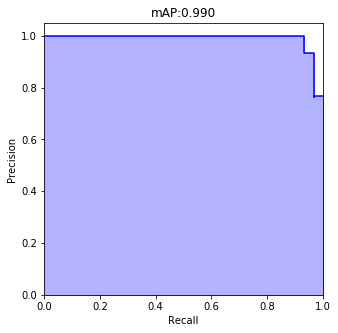

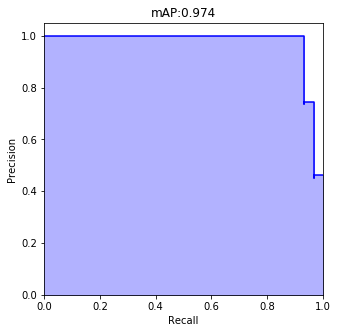

In [13]:
plot_prec_recall(np.concatenate(base_adapt_score_list), np.concatenate(base_adapt_label_list))
plot_prec_recall(np.concatenate(prog_adapt_score_list), np.concatenate(prog_adapt_label_list))

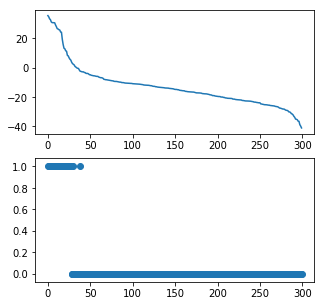

In [15]:
t_i = 0
plot_sorted_scores(base_adapt_score_list[t_i], base_adapt_label_list[t_i], sorting=True)

In [16]:
t_i = 0
plt.figure(figsize=[5, 5])
plt.plot(smooth_score_list[t_i])
plot_sorted_scores(prog_adapt_score_list[t_i], prog_adapt_label_list[t_i])
plot_prec_recall(prog_adapt_score_list[t_i], prog_adapt_label_list[t_i])

NameError: name 'smooth_score_list' is not defined

<Figure size 360x360 with 0 Axes>

In [ ]:
df = adapt_trials[0][-1]

### test trial 

In [ ]:
test_score_list = []
test_label_list = []
for t_i in range(len(prog_adapt_post_idx)):
    trial_info, enr_ids, adapt_trial = adapt_trials[t_i] 
    adapt_trial = (np.array(adapt_trial.id), np.array(adapt_trial.label))
    
    test_trial = test_trials[trial_info['spk']]
    test_trial = (np.array(test_trial.id), np.array(test_trial.label))
    
    init_enr_embeds = get_embeds(enr_ids, sv_embeds,  sv_id2idx, norm=False)
    adapt_embeds = get_embeds(adapt_trial[0], sv_embeds, sv_id2idx, norm=False)
    test_embeds = get_embeds(test_trial[0], sv_embeds, sv_id2idx, norm=False)
    
#     prog_enr_embeds = adapt_embeds[prog_adapt_idx_list[t_i]]
    prog_enr_embeds = np.concatenate([init_enr_embeds, adapt_embeds[prog_adapt_post_idx[t_i]]])
    test_scores = score_trials(prog_enr_embeds, test_embeds, "multiSessScale")
    test_score_list.append(test_scores)
    test_label_list.append(test_trial[1])

compute_eer(np.concatenate(test_score_list), np.concatenate(test_label_list))

In [ ]:
pickle.dump({"base_score":base_adapt_score_list, "base_label":base_adapt_label_list, "prog_score":prog_adapt_score_list, "prog_label":prog_adapt_label_list, "prog_adapt_idx":prog_adapt_idx_list}, 
            open("trials/dev940_eval311/split_trials/adapt_enr1_hard_nostop_result.pkl", "wb"))

## Adaptation Performance 

### Base Adapt

In [ ]:
eT_list = [-4.26, 3.1, 10.32]
# eT_list = [-4.26]

base_pred_list = {k:[] for k in eT_list}
base_adapt_score_list = []
base_enr_embeds = {k:[] for k in eT_list}

for t_i in tqdm(range(0, len(adapt_trials), 1), total=len(adapt_trials)//1):
    trial_info, enr_ids, adapt_trial = adapt_trials[t_i] 
    
    adapt_trial = (np.array(adapt_trial.id), np.array(adapt_trial.label))

    init_enr_embeds = get_embeds(enr_ids, sv_embeds,  sv_id2idx, norm=False)
    adapt_embeds = get_embeds(adapt_trial[0], sv_embeds, sv_id2idx, norm=False) 
    adapt_scores = score_trials(init_enr_embeds, adapt_embeds, "multiSessScale")
    
    base_adapt_score_list.append(adapt_scores)
    for eT in eT_list:
        base_preds = adapt_scores > eT
        base_pred_list[eT].append(base_preds)
                              
        adapted_embeds = adapt_embeds[base_preds]
        enr_embeds = np.concatenate([init_enr_embeds, adapted_embeds])
        base_enr_embeds[eT].append(enr_embeds)

In [ ]:
base_test_score_list = {k:[] for k in eT_list}
for t_i in tqdm(range(0, len(adapt_trials), 1), total=len(adapt_trials)//1):
    trial_info, enr_ids, adapt_trial = adapt_trials[t_i] 
    test_trial = test_trials[trial_info['spk']]
    test_trial = (np.array(test_trial.id), np.array(test_trial.label))
    test_embeds = get_embeds(test_trial[0], sv_embeds, sv_id2idx, norm=False)

    for eT in eT_list:
        enr_embeds = base_enr_embeds[eT][t_i]
        
        test_scores = score_trials(enr_embeds, test_embeds, "multiSessScale")
    
        ## weighting
#         weights = base_adapt_score_list[eT][t_i]
#         n_init = len(enr_embeds) - len(weights) 
#         weights = np.concatenate([[weights.max()]*n_init, weights])
#         test_scores = py_plda_model.multi_sess(enr_embeds, test_embeds, weights=weights, cov_scaling=True).mean(0)

        base_test_score_list[eT].append(test_scores)

In [ ]:
base_recall_prec= {}
for eT in eT_list:
    precision, recall, _, _ = precision_recall_fscore_support(
        adapt_total_labels, np.concatenate(base_pred_list[eT]), average='binary') 
    eer, _, _, ths = compute_eer(np.concatenate(base_test_score_list[eT]), test_total_labels, verbose=False)
    print("eT:{:.3f}, prec:{:.3f}, recall:{:.3f} EER:{:.5f}, THS:{:.3f}".format(eT, precision, recall, eer, ths))
    base_recall_prec[eT] = (recall, precision)

In [ ]:
from utils import compute_error
for eT in eT_list:
    preds = [scores > eT for scores in base_test_score_list[eT]]
    errors = compute_error(np.concatenate(preds), test_total_labels, verbose=False)
    print("eT:{}, ERROR:{:.3f}, FPR:{:.3f}, FNR:{:.3f}".format(eT, errors['error'], errors['fpr'], errors['fnr']))

In [ ]:
# individual prec and recall
for eT in eT_list:
    base_results = {"prec":[], "recall":[], "eer":[], "fscore":[]}
    for i in range(len(adapt_label_list)):
        precision, recall, fscore, _ = precision_recall_fscore_support(
            adapt_label_list[i], base_pred_list[eT][i], average='binary')
        base_results['prec'].append(precision)
        base_results['recall'].append(recall)
        base_results['fscore'].append(fscore)

        test_scores = base_test_score_list[eT][i]
        test_labels = test_label_list[i]
        eer, _, _, ths = compute_eer(test_scores, test_labels, verbose=False)
        base_results['eer'].append(eer)

    #     print("eT:{}, precision:{:.3f}, recall:{:.3f}, EER:{:.3f}%, THS:{:.2f}".format(eT, precision, recall, eer, ths))

    print("[{}] avg_prec = {:.3f}, avg_recall = {:.3f}, avg_fscore = {:.3f}".format(eT, np.mean(base_results['prec']), np.mean(base_results['recall']),  np.mean(base_results['fscore']) ))

### Progressive Adapt 

In [ ]:
base_adapt_scores = []
base_adapt_labels = []
prog_adapt_scores = []
prog_adapt_labels = []

prog_enr_labels = []

stop_eT = 3.1

for t_i in tqdm(range(0, len(adapt_trials), 1), total=len(adapt_trials)//1):
    trial_info, enr_ids, adapt_trial = adapt_trials[t_i] 
    
    
    adapt_trial = (np.array(adapt_trial.id), np.array(adapt_trial.label))

    init_enr_embeds = get_embeds(enr_ids, sv_embeds,  sv_id2idx, norm=False)
    adapt_embeds = get_embeds(adapt_trial[0], sv_embeds, sv_id2idx, norm=False)
    
    adapt_scores = score_trials(init_enr_embeds, adapt_embeds, "multiSessScale")
    
    candt_idx = np.arange(len(adapt_trial[0]))
#     candt_idx = np.nonzero(adapt_scores > stop_eT)[0]
    
    base_adapt_scores.append(adapt_scores[candt_idx])
    base_adapt_labels.append(adapt_trial[1][candt_idx])
    
    candt_sorted_idx = np.flip(np.argsort(adapt_scores[candt_idx]))
    candt_scores = adapt_scores[candt_idx][candt_sorted_idx]
    candt_labels = adapt_trial[1][candt_idx][candt_sorted_idx]
    candt_embeds = adapt_embeds[candt_idx][candt_sorted_idx]

    step_s = 5
    enr_embeds = init_enr_embeds
        
    while(len(candt_embeds) > 0):
        # check stop criterion
#         stop_scores = score_trials(candt_embeds[:step_s], enr_embeds, "multiSessScale")
        stop_scores = score_trials(enr_embeds, candt_embeds[:step_s], "multiSessScale")
        prog_adapt_scores.append(stop_scores)
        prog_adapt_labels += candt_labels[:step_s].tolist()

        # expand enr_embeds
        enr_embeds = np.concatenate([enr_embeds, candt_embeds[:step_s][stop_scores > eT]])

        # update candt embeds and labels
        scores = score_trials(enr_embeds, candt_embeds[step_s:], "multiSessScale")
        candt_sorted_idx = np.flip(np.argsort(scores))
        candt_embeds = candt_embeds[step_s:][candt_sorted_idx]
        candt_labels = candt_labels[step_s:][candt_sorted_idx]

#         candt_embeds = candt_embeds[step_s:]
#         candt_labels = candt_labels[step_s:]

base_adapt_scores = np.concatenate(base_adapt_scores)
base_adapt_labels = np.concatenate(base_adapt_labels)
prog_adapt_scores = np.concatenate(prog_adapt_scores)
prog_adapt_labels = np.array(prog_adapt_labels)

In [ ]:
prog_test_score_list = {k:[] for k in eT_list}
for t_i in tqdm(range(0, len(adapt_trials), 1), total=len(adapt_trials)//1):
    trial_info, enr_ids, adapt_trial = adapt_trials[t_i] 
    test_trial = test_trials[trial_info['spk']]
    test_trial = (np.array(test_trial.id), np.array(test_trial.label))
    test_embeds = get_embeds(test_trial[0], sv_embeds, sv_id2idx, norm=False)

    for eT in eT_list:
        enr_embeds = prog_enr_embeds[eT][t_i]
        test_scores = score_trials(enr_embeds, test_embeds, "multiSessScale")
        prog_test_score_list[eT].append(test_scores)

In [ ]:
n_tars = adapt_total_labels.sum()
prog_recall_prec = {}
for eT in eT_list:
    n_true_adapts = np.sum(prog_true_adapts[eT])
    n_false_adapts = np.sum(prog_false_adapts[eT])
    precision = n_true_adapts / (n_true_adapts + n_false_adapts)
    recall = n_true_adapts / n_tars 
    
    eer, _, _, ths = compute_eer(np.concatenate(prog_test_score_list[eT]), test_total_labels, verbose=False)
    
    print("eT:{:.3f}, prec:{:.3f}, recall:{:.3f} EER:{:.5f}, THS:{:.3f}".format(eT, precision, recall, eer, ths))
    prog_recall_prec[eT] = (recall, precision)

In [ ]:
from utils import compute_error
for eT in eT_list:
    preds = [scores > eT for scores in prog_test_score_list[eT]]
    errors = compute_error(np.concatenate(preds), test_total_labels, verbose=False)
    print("eT:{}, ERROR:{:.3f}, FPR:{:.3f}, FNR:{:.3f}".format(eT, errors['error'], errors['fpr'], errors['fnr']))

In [ ]:
# individual prec and recall
eT = -4.26
for eT in eT_list:
    prog_results = {"prec":[], "recall":[], "eer":[], "fscore":[]}
    for i in range(len(adapt_label_list)):
        n_tars = np.sum(adapt_label_list[i])
        n_true_adapts = prog_true_adapts[eT][i]
        n_false_adapts = prog_false_adapts[eT][i]

        if n_true_adapts + n_false_adapts == 0: continue

        precision = n_true_adapts / (n_true_adapts + n_false_adapts)
        recall = n_true_adapts / n_tars 
        fscore = 2 * (precision * recall) / (precision + recall)
        prog_results['prec'].append(precision)
        prog_results['recall'].append(recall)
        prog_results['fscore'].append(fscore)

        test_scores = prog_test_score_list[eT][i]
        test_labels = test_label_list[i]
        eer, _, _, ths = compute_eer(test_scores, test_labels, verbose=False)
        prog_results['eer'].append(eer)

    #     print("eT:{}, precision:{:.3f}, recall:{:.3f}, EER:{:.3f}%, THS:{:.2f}".format(eT, precision, recall, eer, ths))

    print("[{}] avg_prec = {:.3f}, avg_recall = {:.3f}, avg_fscore = {:.3f}".format(eT, np.mean(prog_results['prec']), np.mean(prog_results['recall']),  np.mean(prog_results['fscore']) ))

In [ ]:
prog_results

## Precision/Recall Graph 

In [ ]:
# prog_recall_prec = {}

# prog_recall_prec[eT_list[0]] = (0.899, 0.959) 
# prog_recall_prec[eT_list[1]] = (0.845, 0.99) 
# prog_recall_prec[eT_list[2]] = (0.684, 0.999)

# prog_recall_prec[eT_list[0]] = (0.796, 0.794) 
# prog_recall_prec[eT_list[1]] = (0.653, 0.8) 
# prog_recall_prec[eT_list[2]] = (0.394, 0.908)

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

eT = eT_list[0]
precision, recall, _ = precision_recall_curve(adapt_total_labels, np.concatenate(base_adapt_score_list))

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

for k, v in base_recall_prec.items():
    plt.annotate("eT={:.2f}".format(k),
                 xy=v, xycoords='data', xytext=(90, 50),
                 textcoords='offset points',
                 fontsize=16, arrowprops=dict(arrowstyle="->", color="k"), color="k")
    
for k, v in prog_recall_prec.items():
    plt.annotate("eT={:.2f}".format(k),
                 xy=v, xycoords='data', xytext=(-90, -50),
                 textcoords='offset points',
                 fontsize=16, arrowprops=dict(arrowstyle="->", color="r"), color="r")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("adapt_enr3_random_trial_300f", loc='left')

In [ ]:
adapt_total_labels

In [ ]:
base_adapt_score_list